[*********************100%***********************]  1 of 1 completed

Скачиваем данные для Apple (AAPL)...


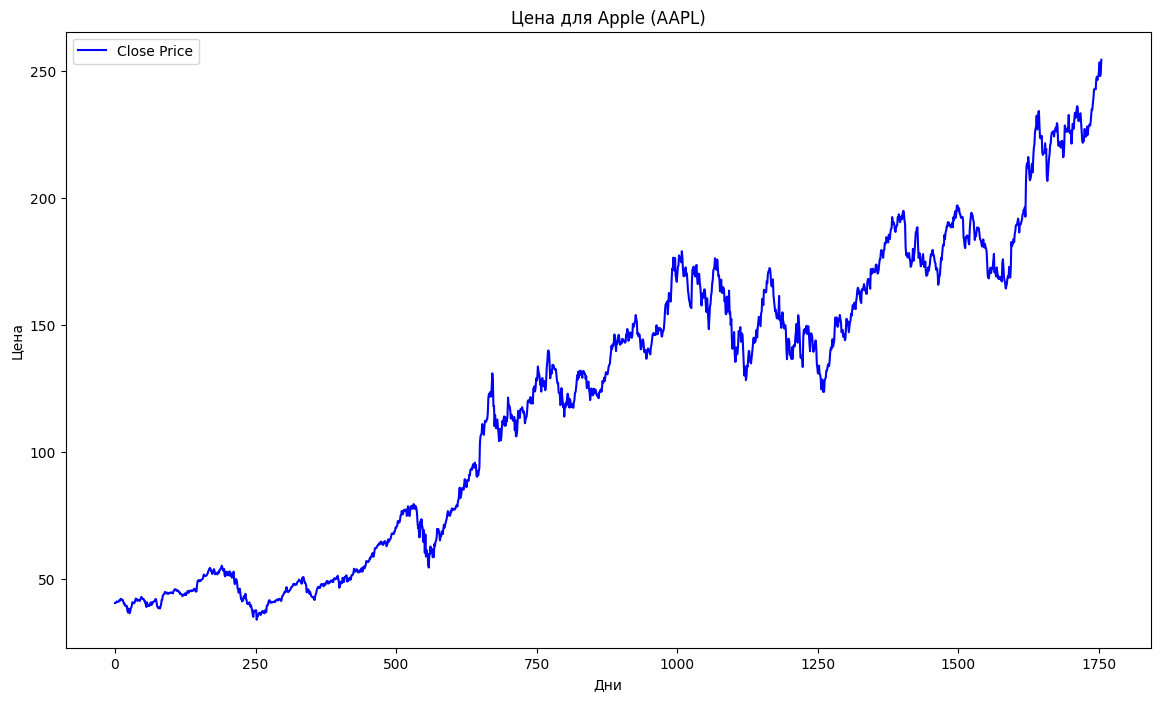

Скачиваем данные для Tesla (TSLA)...


[*********************100%***********************]  1 of 1 completed


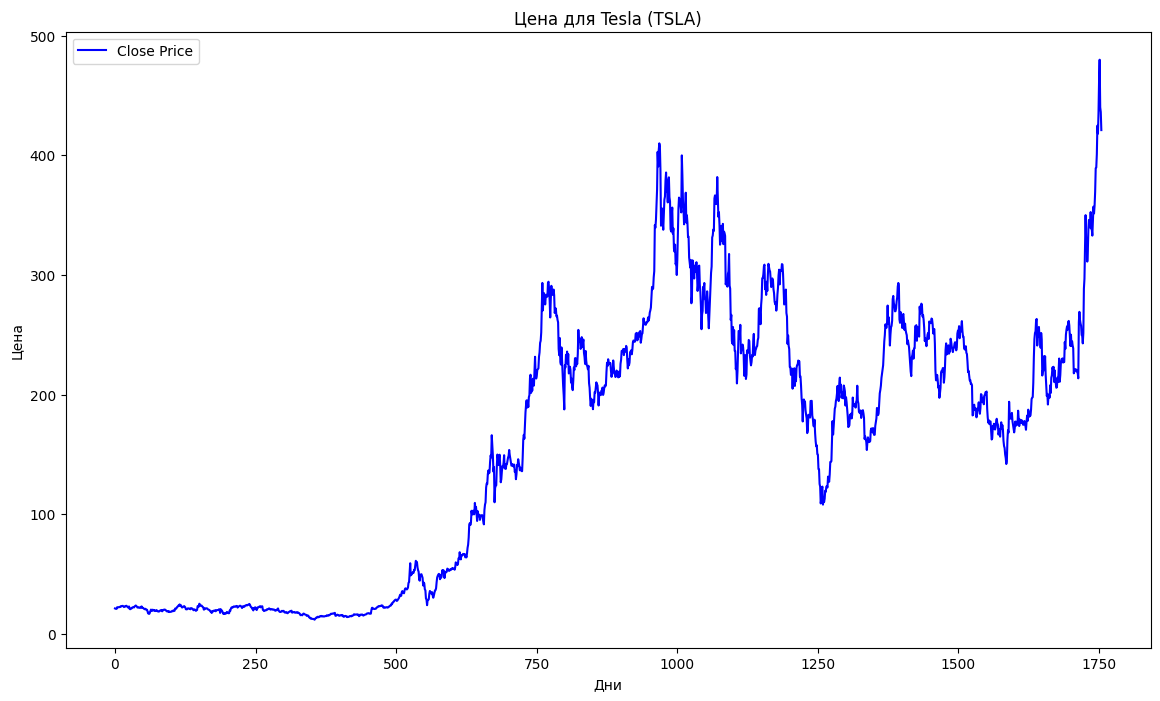

Скачиваем данные для Nvidia (NVDA)...


[*********************100%***********************]  1 of 1 completed


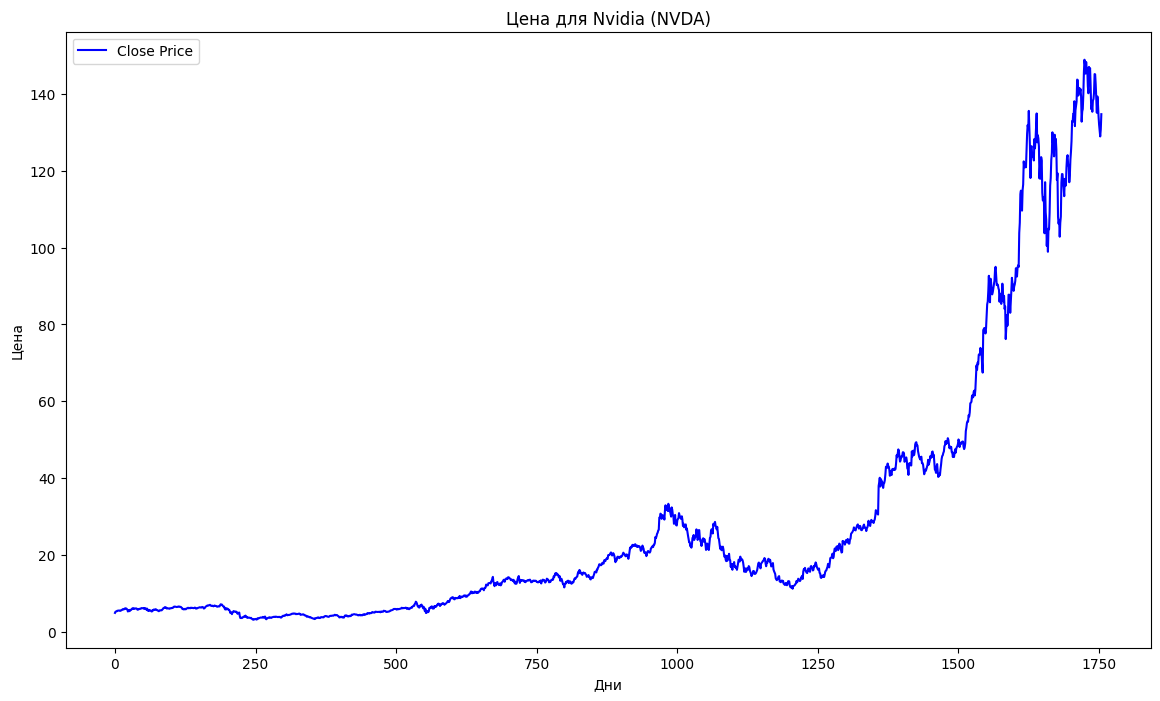

Скачиваем данные для Intel (INTC)...


[*********************100%***********************]  1 of 1 completed


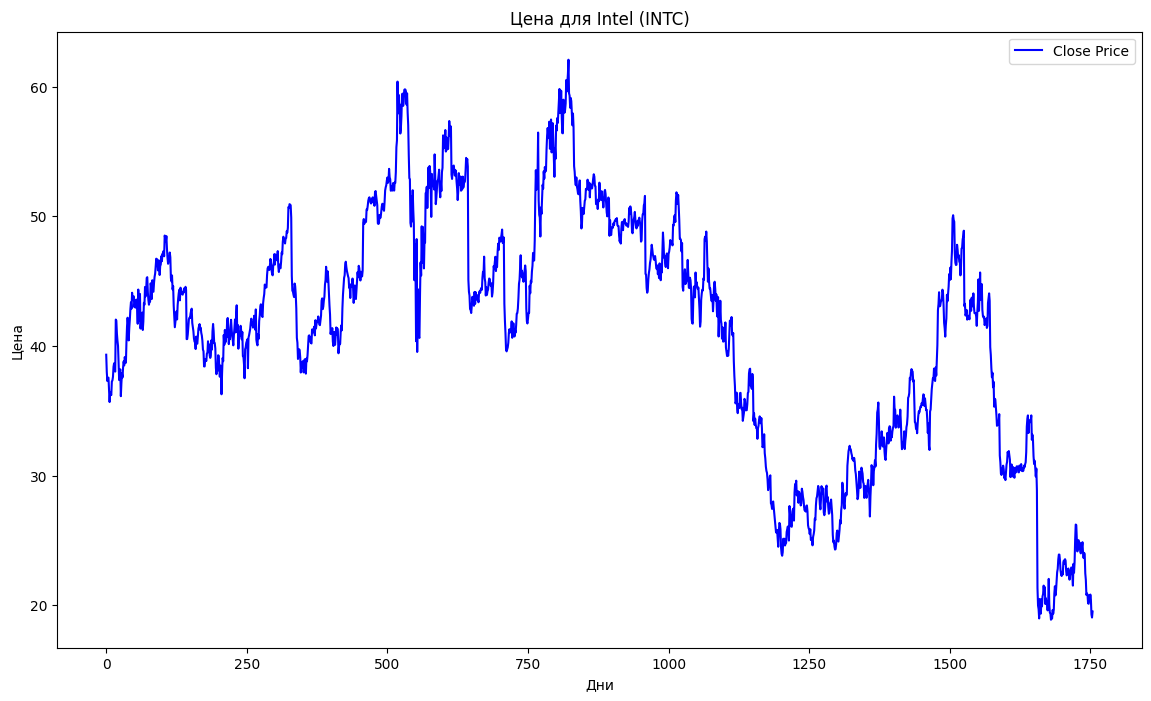

Скачиваем данные для 3M (MMM)...


[*********************100%***********************]  1 of 1 completed


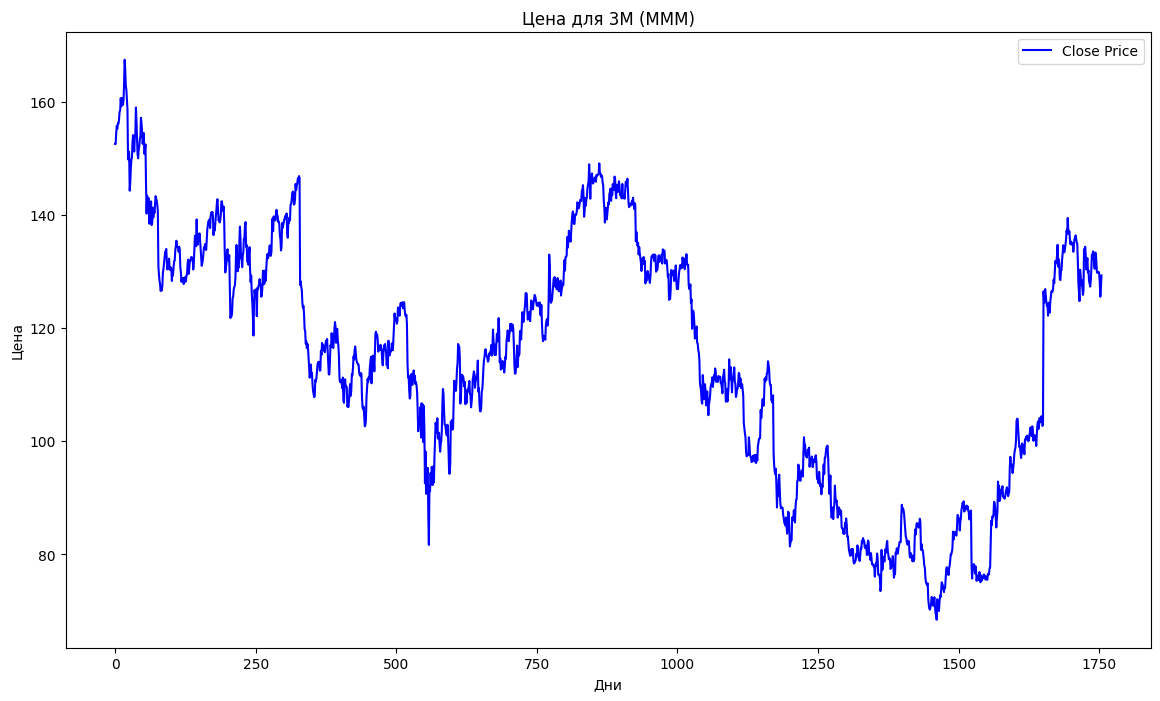

In [75]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

tickers = {
    "Apple": "AAPL",          # Растущий тренд
    "Tesla": "TSLA",     # Колеблющийся тренд тренд
    "Nvidia": "NVDA",         # Растущий тренд
    "Intel": "INTC",          # Падающий тренд
    "3M": "MMM"               # Падающий тренд
}

df_dict = {}
for name, ticker in tickers.items():
    print(f"Скачиваем данные для {name} ({ticker})...")
    df = yf.download(ticker, start="2018-01-01", end="2024-12-23", interval="1d")
    
    if df.empty:
        print(f"Данные для {ticker} отсутствуют.")
        continue

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna().reset_index(drop=True)
    df_dict[name] = df

    plt.figure(figsize=(14, 8))
    plt.title(f"Цена для {name} ({ticker})")
    plt.plot(df['Close'], label='Close Price', color='blue')
    plt.xlabel("Дни")
    plt.ylabel("Цена")
    plt.legend()
    plt.show()

Скачиваем данные для Apple (AAPL)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Скачиваем данные для Tesla (TSLA)...
Скачиваем данные для Nvidia (NVDA)...
Скачиваем данные для Intel (INTC)...
Скачиваем данные для 3M (MMM)...


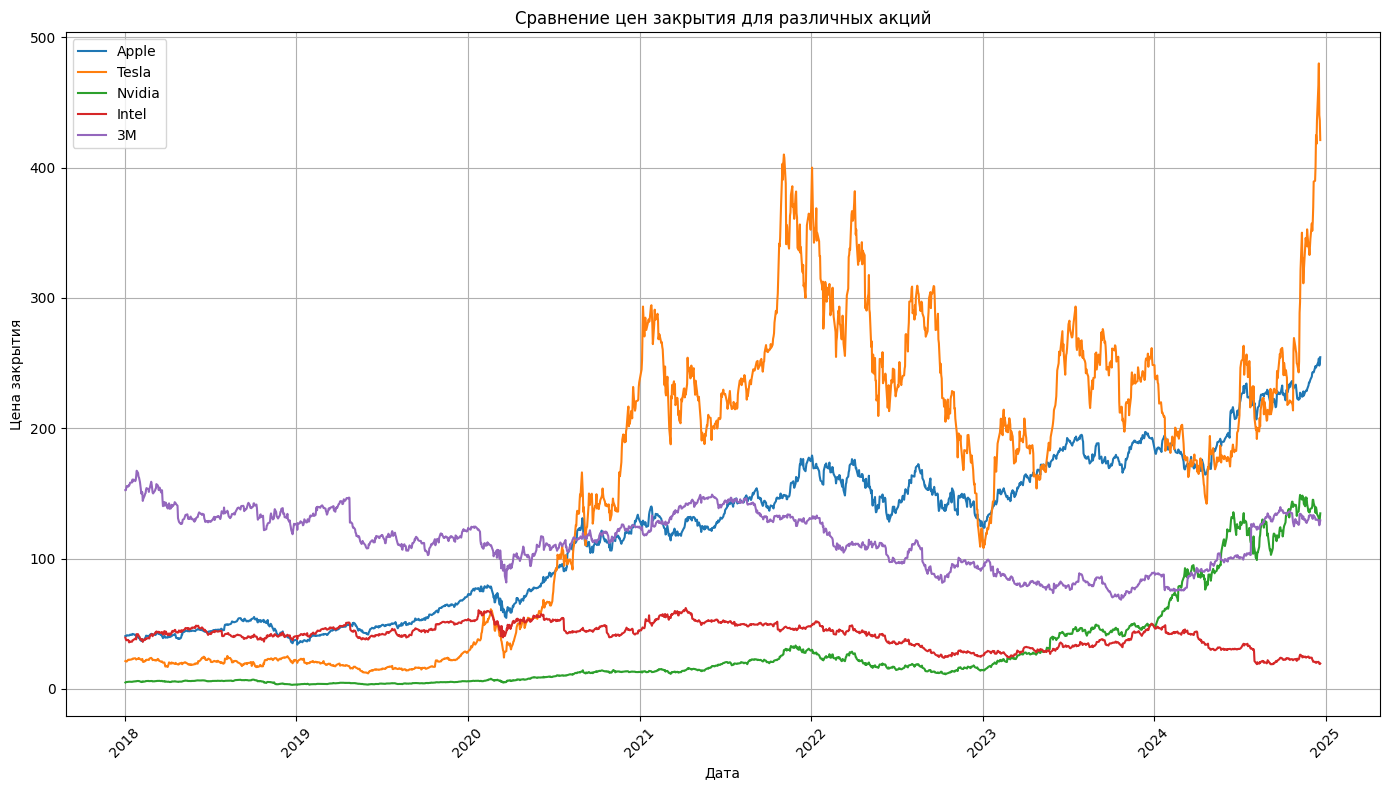

In [74]:
# смотрим как выглдяит акции друг на друге

df_dict = {}
for name, ticker in tickers.items():
    print(f"Скачиваем данные для {name} ({ticker})...")
    df = yf.download(ticker, start="2018-01-01", end="2024-12-23", interval="1d")
    
    if df.empty:
        print(f"Данные для {ticker} отсутствуют.")
        continue

    df = df.reset_index()

    df = df[['Date', 'Close']].dropna()

    df_dict[name] = df

plt.figure(figsize=(14, 8))

for name, df in df_dict.items():
    plt.plot(df['Date'], df['Close'], label=name) 


plt.title("Сравнение цен закрытия для различных акций")
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.legend()  
plt.xticks(rotation=45) 
plt.grid(True)  
plt.tight_layout() 
plt.show()

In [2]:
!pip install stable-baselines3
!pip install gym
!pip install shimmy
!pip install ta

In [76]:
import gym
import numpy as np
import pandas as pd
from gym import spaces

class MultiStockTradingEnv(gym.Env):
    def __init__(self, df_dict, window_size=10, initial_balance=10000, commission=0.005):
        """
        Инициализация торговой среды.

        Параметры:
        - df_dict: Словарь с историческими данными по каждому активу (DataFrame).
        - window_size: Количество временных шагов для анализа (окно наблюдения).
        - initial_balance: Начальный баланс агента.
        - commission: Комиссия за каждую сделку (в долях от суммы).
        """
        super().__init__()

        self.df_dict = {ticker: df.copy() for ticker, df in df_dict.items()}
        self.window_size = window_size
        self.initial_balance = float(initial_balance)
        self.commission = float(commission)

        for ticker, df in self.df_dict.items():
            if "Close" not in df.columns:
                raise ValueError(f"DataFrame для {ticker} не содержит колонку 'Close'")

            df["SMA"] = df["Close"].rolling(window_size).mean() 
            df["EMA"] = df["Close"].ewm(span=window_size, adjust=False).mean() 
            
            delta = df["Close"].diff()
            gain = delta.where(delta > 0, 0).rolling(window=14).mean()
            loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
            rs = gain / loss
            df["RSI"] = 100 - (100 / (1 + rs))
            
            high_low = df["High"] - df["Low"]
            high_close = abs(df["High"] - df["Close"].shift())
            low_close = abs(df["Low"] - df["Close"].shift())
            true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
            df["ATR"] = true_range.rolling(window=14).mean()

            df.fillna(method='bfill', inplace=True)
            df.fillna(method='ffill', inplace=True)
            
        self.tickers = list(self.df_dict.keys())
        self.num_stocks = len(self.tickers)

        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(2 * window_size * self.num_stocks,), dtype=np.float32
        )

        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(self.num_stocks,), dtype=np.float32
        )

        self.reset()

    def seed(self, seed=None):
        """
        Устанавливает случайное зерно для воспроизводимости.
        """
        np.random.seed(seed)
        self.action_space.seed(seed)
        self.observation_space.seed(seed)

    def reset(self):
        """
        Сбрасывает состояние среды в начальное.
        Устанавливает начальный баланс, обнуляет акции и возвращает первое наблюдение.
        """
        self.balance = float(self.initial_balance)
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.current_step = self.window_size  
        self.prev_portfolio_value = self.balance
        return self._get_observation()

    def _get_observation(self):
        """
        Возвращает текущие данные наблюдений за последние `window_size` шагов.

        Для каждого тикера:
        - Цены закрытия (Close).
        - Скользящее среднее (SMA).
        """
        obs = []
        for ticker in self.tickers:
            df = self.df_dict[ticker]
            window_data = df.iloc[self.current_step - self.window_size : self.current_step]
            prices = window_data["Close"].values.flatten()
            sma = window_data["SMA"].values.flatten()
            obs.extend(prices)
            obs.extend(sma)
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        """
        Выполняет шаг среды, обрабатывая действия агента.

        Параметры:
        - action: массив [-1, 1] для каждого тикера:
            - 1: купить на весь доступный баланс.
            - -1: продать все имеющиеся акции.
            - 0: удерживать.

        Возвращает:
        - obs: новые наблюдения.
        - reward: награда за текущий шаг.
        - done: флаг завершения эпизода.
        - info: дополнительная информация (стоимость портфеля).
        """
        done = False
        portfolio_value = self.balance  

        for i, ticker in enumerate(self.tickers):
            df = self.df_dict[ticker]
            current_price = float(df["Close"].iloc[self.current_step])  

            act = action[i]
            if act > 0:  
                shares_to_buy = int((self.balance * act) / current_price)
                cost = shares_to_buy * current_price * (1 + self.commission)
                if shares_to_buy > 0 and cost <= self.balance:
                    self.balance -= cost
                    self.shares_held[ticker] += shares_to_buy

            elif act < 0:  
                shares_to_sell = int(self.shares_held[ticker] * (-act))
                revenue = shares_to_sell * current_price * (1 - self.commission)
                if shares_to_sell > 0 and shares_to_sell <= self.shares_held[ticker]:
                    self.balance += revenue
                    self.shares_held[ticker] -= shares_to_sell

            portfolio_value += self.shares_held[ticker] * current_price

        self.current_step += 1
        if self.current_step >= len(next(iter(self.df_dict.values()))):
            done = True

        # Рассчитываем награду
        reward = (portfolio_value - self.prev_portfolio_value) / self.initial_balance
        reward -= abs(sum(action)) * 0.01  # Штраф за агрессивные действия
        
        self.prev_portfolio_value = portfolio_value

        obs = self._get_observation() if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, done, {"portfolio_value": portfolio_value}    

# Разделяем на train/test и делаем нормализацию

In [77]:
split_idx = 0.8  
train_data_dict = {}
test_data_dict = {}

for ticker, df in df_dict.items():
    split_index = int(len(df) * split_idx)
    train_data_dict[ticker] = df.iloc[:split_index].copy()
    test_data_dict[ticker] = df.iloc[split_index:].copy()

print("Train sizes:", {ticker: len(data) for ticker, data in train_data_dict.items()})
print("Test sizes:", {ticker: len(data) for ticker, data in test_data_dict.items()})

Train sizes: {'Apple': 1404, 'Tesla': 1404, 'Nvidia': 1404, 'Intel': 1404, '3M': 1404}
Test sizes: {'Apple': 351, 'Tesla': 351, 'Nvidia': 351, 'Intel': 351, '3M': 351}


In [78]:
# Нормализация данных
normalization_params = {}

def normalize_data(train_data_dict, test_data_dict):
    global normalization_params 
    normalization_params = {}
    
    for ticker, df in train_data_dict.items():
        normalization_params[ticker] = {}
        for column in ['Close', 'SMA', 'EMA', 'RSI', 'ATR']:
            if column in df.columns:
                mean = df[column].mean()
                std = df[column].std()
                normalization_params[ticker][column] = (mean, std)
                train_data_dict[ticker][column] = (train_data_dict[ticker][column] - mean) / std
                test_data_dict[ticker][column] = (test_data_dict[ticker][column] - mean) / std



normalize_data(train_data_dict, test_data_dict)

print("Train sizes after normalization:", {ticker: len(data) for ticker, data in train_data_dict.items()})
print("Test sizes after normalization:", {ticker: len(data) for ticker, data in test_data_dict.items()})

Train sizes after normalization: {'Apple': 1404, 'Tesla': 1404, 'Nvidia': 1404, 'Intel': 1404, '3M': 1404}
Test sizes after normalization: {'Apple': 351, 'Tesla': 351, 'Nvidia': 351, 'Intel': 351, '3M': 351}


In [79]:
train_data_dict

{'Apple': Price         Open        High         Low     Close     Volume
 Ticker        AAPL        AAPL        AAPL      AAPL       AAPL
 0        40.030320   40.533757   39.818592 -1.277513  102223600
 1        40.587857   41.063065   40.453765 -1.277658  118071600
 2        40.590208   40.808994   40.481995 -1.273800   89738400
 3        40.801943   41.255976   40.710195 -1.264302   94640000
 4        41.016014   41.312429   40.917206 -1.267436   82271200
 ...            ...         ...         ...       ...        ...
 1399    192.212697  194.167875  191.865340  1.848181   47471900
 1400    194.545032  195.716146  191.101141  1.822146   47460200
 1401    193.205155  195.150413  192.679144  1.875234   48291400
 1402    194.584722  195.011494  193.790738  1.887845   38824100
 1403    194.763387  195.249690  193.810604  1.870760   35175100
 
 [1404 rows x 5 columns],
 'Tesla': Price         Open        High         Low     Close     Volume
 Ticker        TSLA        TSLA        TSLA 

In [80]:
import gym
from stable_baselines3.common.vec_env import DummyVecEnv


window_size = 20
initial_balance = 10000
commission = 0.005

def make_env(data_dict):

    env = MultiStockTradingEnv(df_dict=data_dict,
                               window_size=window_size,
                               initial_balance=initial_balance,
                               commission=commission)
    return env

train_env = DummyVecEnv([lambda: make_env(train_data_dict)])
test_env = DummyVecEnv([lambda: make_env(test_data_dict)])

/Users/yarusskiyilya/anaconda3/envs/PythonBot/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/yarusskiyilya/anaconda3/envs/PythonBot/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


# Тестируем другие алгоритмы без обучения

Using cpu device


/var/folders/nr/rnc72dkn53v593_t7w0pmc9w0000gn/T/ipykernel_37562/3300393231.py:117: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(df["Close"].iloc[self.current_step])


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 155      |
|    time_elapsed    | 35       |
|    total_timesteps | 5536     |
| train/             |          |
|    actor_loss      | -0.467   |
|    critic_loss     | 0.017    |
|    ent_coef        | 0.01     |
|    learning_rate   | 0.003    |
|    n_updates       | 1080     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 109      |
|    time_elapsed    | 101      |
|    total_timesteps | 11072    |
| train/             |          |
|    actor_loss      | -0.596   |
|    critic_loss     | 0.00722  |
|    ent_coef        | 0.01     |
|    learning_rate   | 0.003    |
|    n_updates       | 2190     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps      

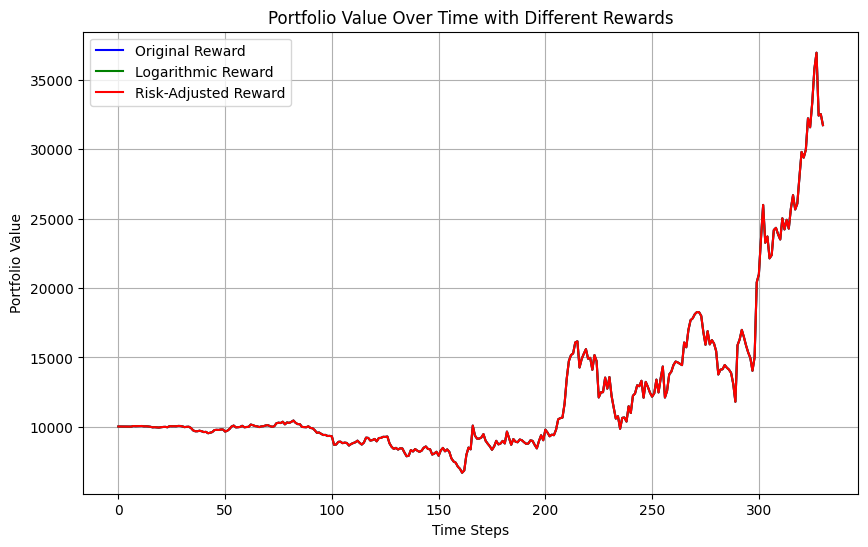

In [ ]:
from stable_baselines3 import SAC
import matplotlib.pyplot as plt
import numpy as np

model = SAC(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=3e-3, 
    buffer_size=200000,     
    batch_size=64,  
    tau=0.02,                 
    gamma=0.99,                
    train_freq=50,            
    gradient_steps=10,         
    verbose=1,
    ent_coef=0.01,             
    seed=42
)

total_timesteps = 30000  
model.learn(total_timesteps=total_timesteps)

def test_model(env, model, reward_type="original"):
    obs = env.reset()
    done = False

    portfolio_values = []
    initial_balance = env.envs[0].initial_balance  
    prev_portfolio_value = initial_balance
    step_i = 0

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done_flags, info = env.step(action)
        done = done_flags[0]

        current_portfolio_value = info[0]["portfolio_value"]
        
        if reward_type == "original":
            adjusted_reward = reward
        elif reward_type == "logarithmic":
            adjusted_reward = (current_portfolio_value - prev_portfolio_value) / initial_balance
            adjusted_reward = np.log1p(adjusted_reward) if adjusted_reward > 0 else -np.log1p(-adjusted_reward)
        elif reward_type == "risk_adjusted":
            volatility_penalty = 1 - (0.005 * (step_i % 10))
            adjusted_reward = ((current_portfolio_value - prev_portfolio_value) / initial_balance) * volatility_penalty
        else:
            raise ValueError(f"Unknown reward type: {reward_type}")
        
        portfolio_values.append(current_portfolio_value)
        prev_portfolio_value = current_portfolio_value
        step_i += 1

    if len(portfolio_values) == 0:
        print(f"No portfolio values recorded for reward type: {reward_type}")

    return portfolio_values

try:
    portfolio_values_original = test_model(test_env, model, reward_type="original")
    portfolio_values_log = test_model(test_env, model, reward_type="logarithmic")
    portfolio_values_risk_adjusted = test_model(test_env, model, reward_type="risk_adjusted")
except Exception as e:
    print(f"Error during testing: {e}")

print(f"Original Reward Length: {len(portfolio_values_original)}")
print(f"Logarithmic Reward Length: {len(portfolio_values_log)}")
print(f"Risk-Adjusted Reward Length: {len(portfolio_values_risk_adjusted)}")

plt.figure(figsize=(10, 6))
plt.plot(portfolio_values_original, label="Original Reward", color="blue")
plt.plot(portfolio_values_log, label="Logarithmic Reward", color="green")
plt.plot(portfolio_values_risk_adjusted, label="Risk-Adjusted Reward", color="red")

plt.title("Portfolio Value Over Time with Different Rewards")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# Обучаем наш алгоритм

In [ ]:
from stable_baselines3 import SAC
model = SAC(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=3e-3, 
    buffer_size=200000,     
    batch_size=64,  
    tau=0.02,                 
    gamma=0.99,                
    train_freq=50,            
    gradient_steps=10,         
    verbose=1,
    ent_coef=0.01,             
    seed=42
)

total_timesteps = 30000  
model.learn(total_timesteps=total_timesteps)

Using cpu device


/var/folders/nr/rnc72dkn53v593_t7w0pmc9w0000gn/T/ipykernel_37562/2025287863.py:127: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(df["Close"].iloc[self.current_step])  # Текущая цена


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 95       |
|    time_elapsed    | 58       |
|    total_timesteps | 5536     |
| train/             |          |
|    actor_loss      | -0.377   |
|    critic_loss     | 0.00685  |
|    ent_coef        | 0.01     |
|    learning_rate   | 0.003    |
|    n_updates       | 1080     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 93       |
|    time_elapsed    | 118      |
|    total_timesteps | 11072    |
| train/             |          |
|    actor_loss      | -0.659   |
|    critic_loss     | 0.0178   |
|    ent_coef        | 0.01     |
|    learning_rate   | 0.003    |
|    n_updates       | 2190     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps      

/var/folders/nr/rnc72dkn53v593_t7w0pmc9w0000gn/T/ipykernel_37562/2025287863.py:127: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(df["Close"].iloc[self.current_step])  # Текущая цена


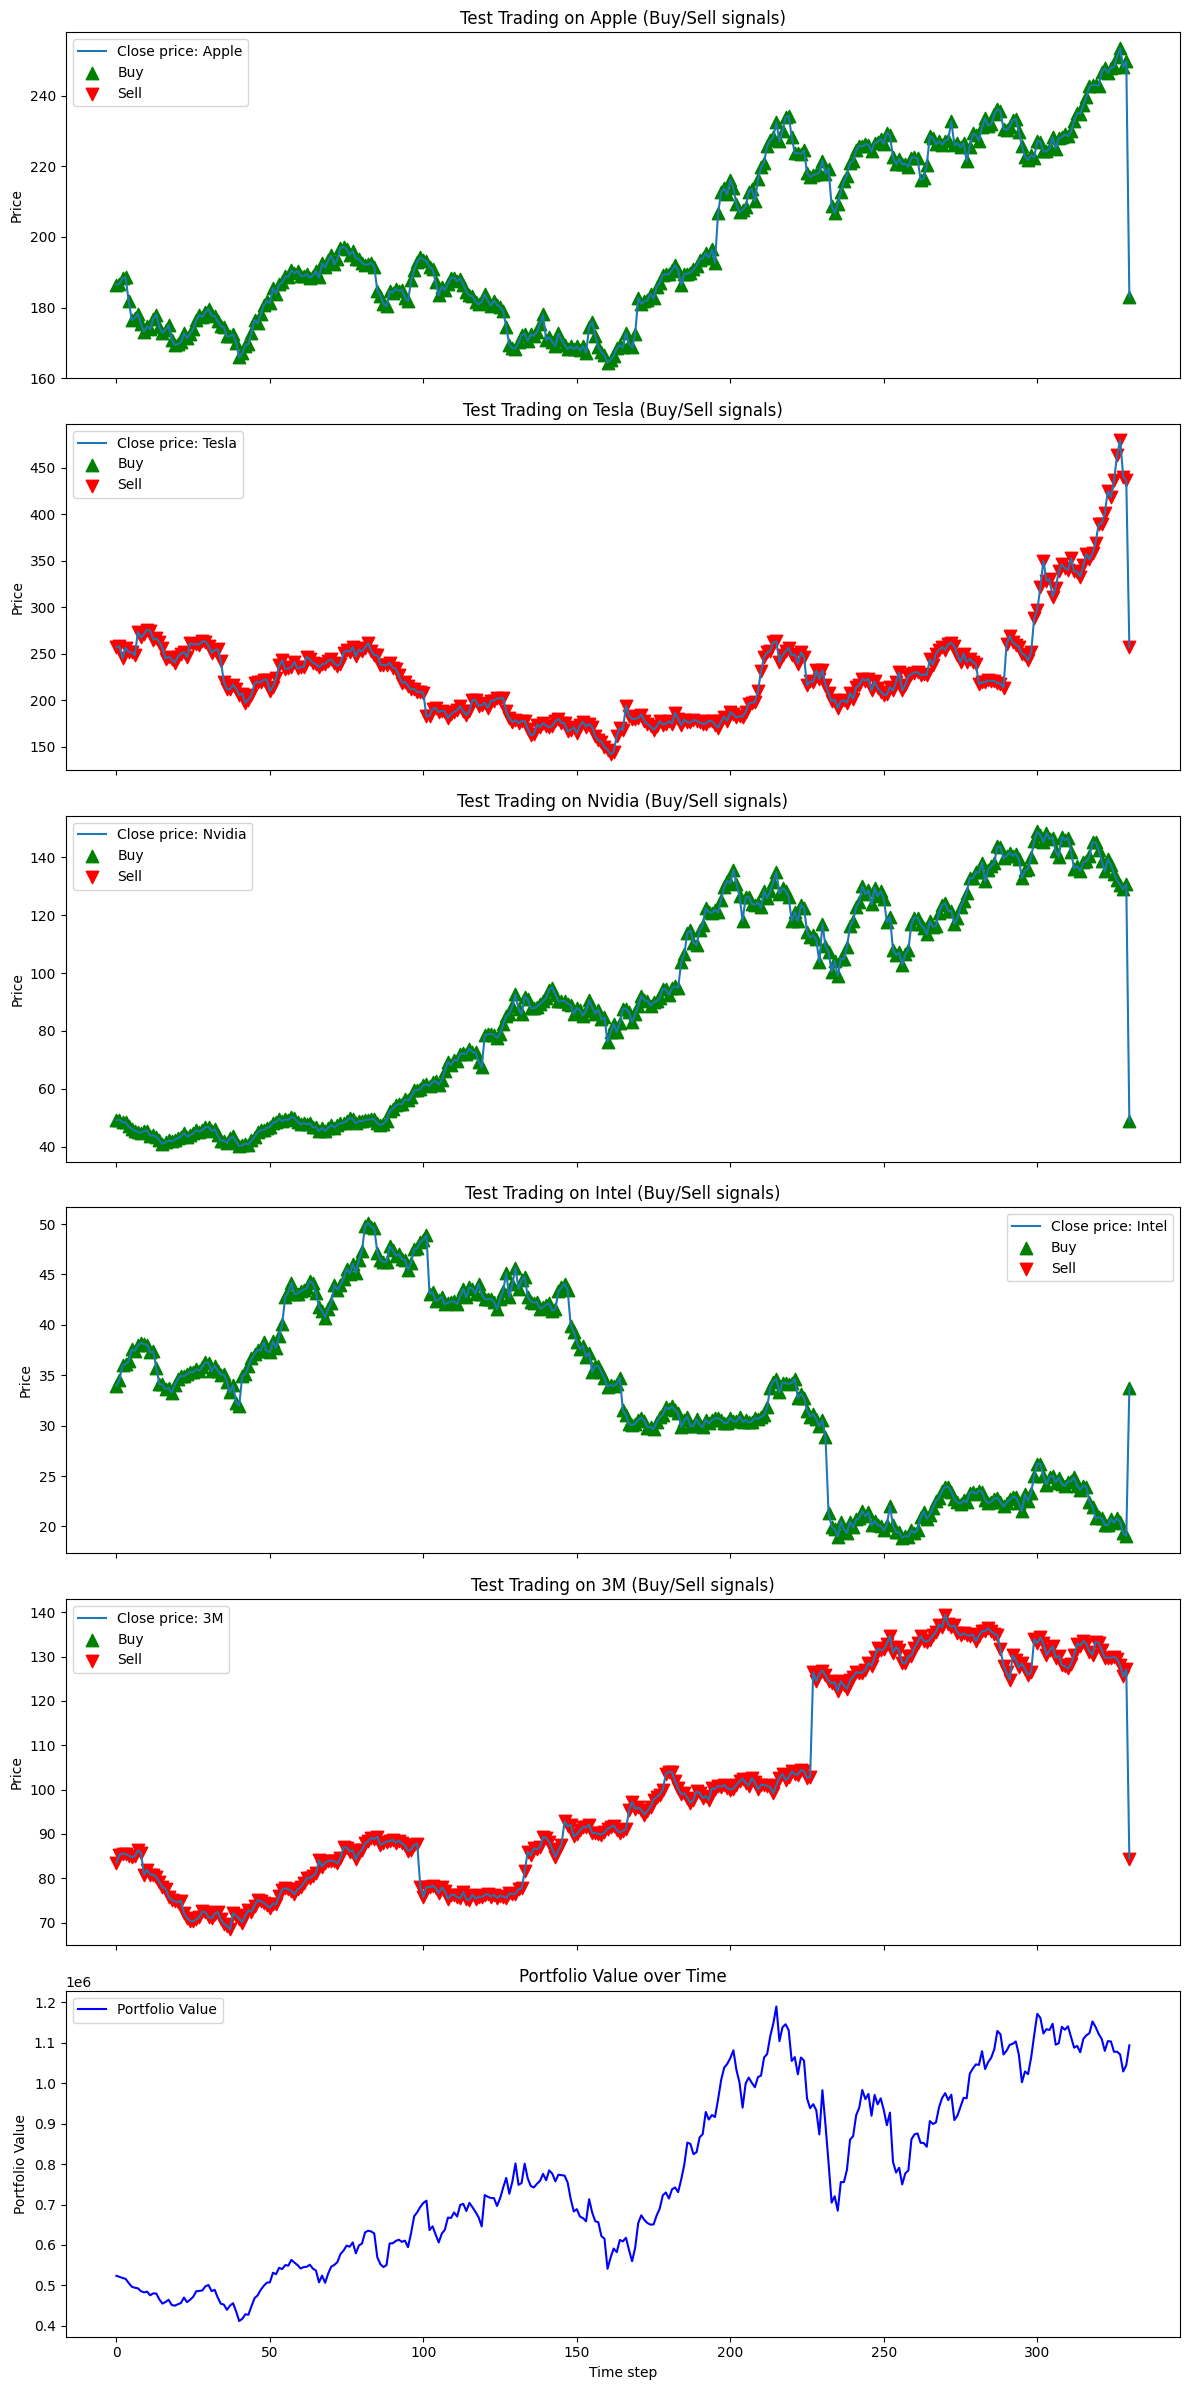

In [ ]:
# Сбросим окружение
obs = test_env.reset()
env = test_env.envs[0]  
done = False

portfolio_values = []  
actions_over_time = {ticker: [] for ticker in env.tickers}  
close_prices = {ticker: [] for ticker in env.tickers}  
buy_indices = {ticker: [] for ticker in env.tickers} 
sell_indices = {ticker: [] for ticker in env.tickers} 

step_i = 0

while not done:

    action, _states = model.predict(obs, deterministic=True)
    

    obs, reward, done_flags, info = test_env.step(action)
    done = done_flags[0]

    current_portfolio_value = info[0]["portfolio_value"]
    portfolio_values.append(current_portfolio_value)
    
    for i, ticker in enumerate(env.tickers):
        mean, std = normalization_params[ticker]['Close']
        current_price_normalized = env.df_dict[ticker]["Close"].iloc[env.current_step - 1]
        current_price = current_price_normalized * std + mean
        close_prices[ticker].append(current_price)
        
        action_ticker = action[0][i] 
        actions_over_time[ticker].append(action_ticker)
        
        if action_ticker > 0:
            buy_indices[ticker].append(step_i)
        elif action_ticker < 0:
            sell_indices[ticker].append(step_i)

    step_i += 1

portfolio_values_original = [
    value * normalization_params[env.tickers[0]]['Close'][1] + normalization_params[env.tickers[0]]['Close'][0]
    for value in portfolio_values
]

fig, axs = plt.subplots(nrows=len(env.tickers) + 1, ncols=1, figsize=(12, 4 * (len(env.tickers) + 1)), sharex=True)

for idx, ticker in enumerate(env.tickers):
    ax = axs[idx]
    ax.plot(close_prices[ticker], label=f"Close price: {ticker}")
    ax.scatter(buy_indices[ticker], [close_prices[ticker][i] for i in buy_indices[ticker]],
               marker="^", color="green", label="Buy", s=80)
    ax.scatter(sell_indices[ticker], [close_prices[ticker][i] for i in sell_indices[ticker]],
               marker="v", color="red", label="Sell", s=80)
    ax.set_ylabel("Price")
    ax.legend()
    ax.set_title(f"Test Trading on {ticker} (Buy/Sell signals)")

mean, std = normalization_params[env.tickers[0]]['Close'] 
portfolio_values_original = [value * std + mean for value in portfolio_values]

axs[-1].plot(portfolio_values_original, label="Portfolio Value", color="blue")
axs[-1].set_xlabel("Time step")
axs[-1].set_ylabel("Portfolio Value")
axs[-1].legend()
axs[-1].set_title("Portfolio Value over Time")

plt.tight_layout()
plt.show()

In [71]:
portfolio_values_original

[10731.336495486732,
 10679.315756900505,
 10620.864364997002,
 10578.13614979853,
 10366.434218488746,
 10183.469270078644,
 10126.052209216723,
 10099.00895291312,
 9952.99980151049,
 9892.73059808027,
 9928.557067240687,
 9744.101010890632,
 9844.18620489872,
 9831.934013378597,
 9531.930752308825,
 9324.195767296735,
 9406.431522095667,
 9517.37715075285,
 9255.211481563925,
 9217.342952545292,
 9288.224767388201,
 9351.280758509618,
 9629.61256423098,
 9395.472639597612,
 9520.526709069256,
 9666.379381180343,
 9945.520826380303,
 9969.554491842027,
 9991.04867504896,
 10200.544015080279,
 10268.102731443198,
 9954.345714623345,
 10023.027429293756,
 9634.555454783089,
 9316.99206616074,
 9274.41397824331,
 9005.604235011224,
 9221.56258553184,
 9342.081836835592,
 8924.590203168538,
 8441.407539616928,
 8553.05766811017,
 8780.636658226804,
 8759.9324602265,
 9191.073522538245,
 9597.669690214267,
 9739.20361761248,
 10019.768607078731,
 10224.53412792893,
 10383.239709570995,
 1

In [ ]:
mean, std = normalization_params[env.tickers[0]]['Close'] 
portfolio_values_original1 = [value for value in portfolio_values]
print(portfolio_values_original1) 3 128

[10899.813842506917, 10821.36629902268, 10608.701996728227, 10691.478923200564, 10501.449883189913, 10398.501741232902, 10245.07784266308, 10838.14724284246, 10600.21790707163, 10715.06168299407, 10838.246465324095, 10630.732369894755, 10281.335935808404, 10265.403902159514, 9984.366174478504, 9586.681778428376, 9181.617808949022, 9304.973350212802, 9136.390698389068, 9016.253908991057, 9325.012651713998, 9525.672207019983, 9706.192282283837, 9332.526170111227, 10064.881842963652, 10071.657423257897, 10200.010515418711, 10097.585977855739, 10343.938455402946, 10413.865871226197, 10219.02111254234, 9667.477067437158, 9870.340067438348, 9677.193315059982, 8866.920263214326, 7710.145681776901, 7214.245086094306, 7392.147239483036, 7696.172219680346, 7270.588805787436, 6756.677889676812, 6854.9789488361, 6409.394166773258, 6547.728543477665, 6972.801930549663, 7783.999460606603, 8030.487791628937, 8078.01028404094, 8255.122011266687, 8321.195654271281, 7718.427481585673, 8121.429242955848,

In [ ]:
mean, std = normalization_params[env.tickers[0]]['Close'] 
portfolio_values_original3 = [value for value in portfolio_values]
print(portfolio_values_original3) 3 64

[10026.842760660107, 10026.202172346028, 10020.174518520505, 10028.724150654829, 10024.346228360739, 10023.615106665966, 10018.620800766268, 10059.295823479451, 10048.027325648885, 10055.220991300319, 10065.28800376283, 10062.092589232296, 10037.744879987373, 10041.26489113035, 10029.743715254994, 10007.147429784025, 9969.529427214384, 9977.611744180631, 9965.64290347404, 9950.617843908301, 9976.691076380435, 9994.185654519582, 10000.057326953594, 9974.152253454886, 10051.387235629642, 10044.957393219658, 10047.659306048972, 10042.304913651924, 10065.917445415664, 10062.807908483097, 10035.16873715226, 9983.697327953749, 10002.491085515145, 10009.17458113746, 9920.184042655306, 9749.253833894085, 9685.540776012236, 9686.185423096324, 9723.301836240633, 9687.054458221435, 9626.228903173054, 9640.694562288994, 9542.761318967641, 9578.155668078947, 9629.453911471765, 9770.477065989971, 9786.468519620397, 9778.15475333942, 9812.717582171721, 9811.730347192295, 9661.073497655823, 9720.15690

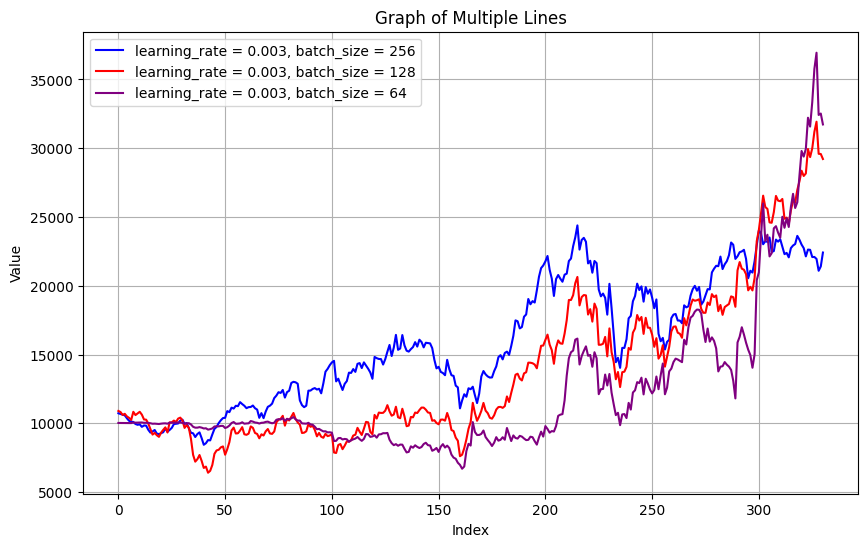

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.plot(portfolio_values_original, label='learning_rate = 0.003, batch_size = 256', color='blue')
plt.plot(portfolio_values_original1, label='learning_rate = 0.003, batch_size = 128', color='red')
plt.plot(portfolio_values_original3, label='learning_rate = 0.003, batch_size = 64', color='purple')

plt.title('Graph of Multiple Lines')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.grid()
plt.show()